In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Machine Learning
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0-rc1


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Dataset for machine learning.
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  # Create a dataset of tensors.
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Drop remaining values so we get same size.
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # The dataset contains a tensor with size of 5.
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Split into two arrays, one for inputs and one for labels.
  dataset = dataset.map(lambda window: (window[ : -1], window[-1 : ]))

  # Shuffle the dataset.
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches. The 'prefetch' indicates the Tensorflow will
  # fetch the data while working, so we always have data to use.
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

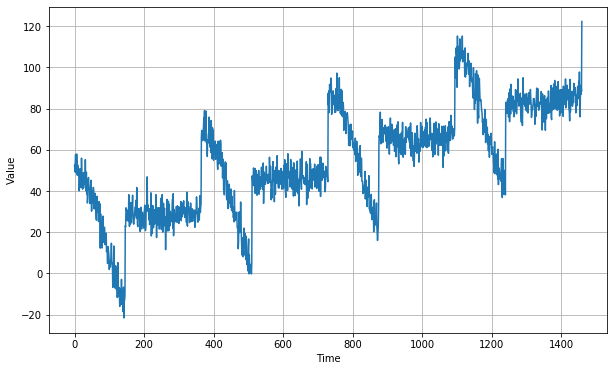

In [4]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
time_valid    = time[split_time:]
series_train  = series[:split_time]
series_valid  = series[split_time:]

In [6]:
# ==================
# Linear Model
# ==================
# Clear session, just useful under development, as we usually
# run the session multiple time in the notebook.
EPOCHS      = 100
SEED        = 42
WINDOW_SIZE = 30
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE)
dataset_valid = window_dataset(series_valid, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape = [WINDOW_SIZE])
])
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
  metrics = ["mae"]
)
model.fit(dataset_train, epochs = EPOCHS, validation_data = dataset_valid)

Epoch 1/100
31/31 [==============================] - 2s 74ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 9.8460 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - los

In [7]:
# Automatically to find an optimal "window size".
# Otherwise we have to manually try different sizes.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE)
dataset_valid = window_dataset(series_valid, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape = [WINDOW_SIZE])
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: 1e-6 * 10**(epoch / 30)
)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(dataset_train, epochs = EPOCHS, callbacks = [lr_scheduler])

Epoch 1/100
31/31 [==============================] - 0s 14ms/step - loss: 82.9639 - mae: 83.6628
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 67.9001 - mae: 68.1054
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 49.7048 - mae: 50.2020
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 30.3629 - mae: 31.0492
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 14.0209 - mae: 14.7116
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 9.9953 - mae: 10.5442
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 10.0889 - mae: 10.5033
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 10.0395 - mae: 10.5074
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 9.9270 - mae: 10.4724
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 9.8859 - mae: 10.4418
Epoch 11/100
31/31 [=====================

[1e-06, 0.001, 0, 20]

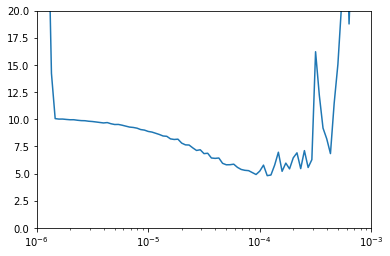

In [8]:
# Plot the learning rate.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [0]:
# As we see that it would be safe to start with 1e-5.

In [10]:
# We can auto stop the training when the training starts to
# stop making progress.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE)
dataset_valid = window_dataset(series_valid, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape = [WINDOW_SIZE])
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
  metrics = ["mae"]
)
model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping]
)

Epoch 1/500
31/31 [==============================] - 1s 19ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8460 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 11ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 11ms/step - lo

In [0]:
# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
linear_forecast = model_forecast(
  model,
  series[split_time - WINDOW_SIZE : -1],
  WINDOW_SIZE
)[:, 0]

In [17]:
print("Shape:", linear_forecast.shape)

Shape: (461,)


MAE: 5.3433857


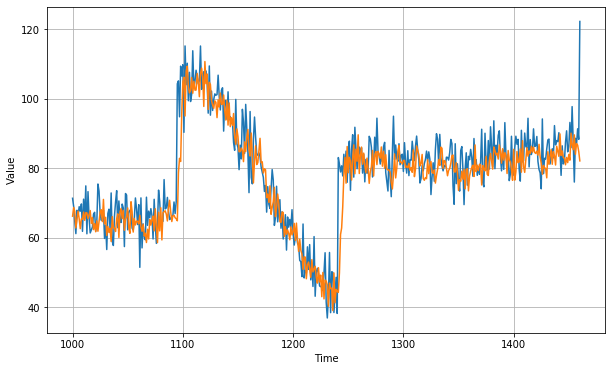

In [18]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, linear_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, linear_forecast).numpy()
print("MAE:", mae)

In [19]:
# ==================
# Dense Model
# ==================
# Start to find an optimal learning rate.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation = "relu", input_shape = [WINDOW_SIZE]),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: 1e-7 * 10**(epoch / 20)
)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(
  dataset_train,
  epochs = EPOCHS,
  callbacks = [lr_scheduler]
)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 43.7565 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 41.8288 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 38.7457 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 35.3772 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 31.4448 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 27.2989 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 22.6964 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 17.6484 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 12.6114 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 8.6302 - mae: 9.0650
Epoch 11/100
31/31 [====================

[1e-07, 0.005, 0, 30]

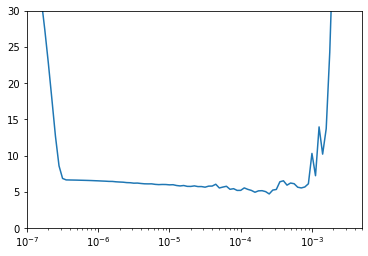

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [0]:
# Seems good start around 1e-5

In [21]:
# Start training with early stopping.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = window_dataset(series_train, WINDOW_SIZE)
dataset_valid = window_dataset(series_valid, WINDOW_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation = "relu", input_shape = [WINDOW_SIZE]),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
  metrics = ["mae"]
)
model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping]
)

Epoch 1/500
31/31 [==============================] - 1s 24ms/step - loss: 20.0335 - mae: 20.8270 - val_loss: 12.7604 - val_mae: 13.4040
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 8.6268 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 7.9271 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 7.6027 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 7.3532 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 7.1958 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 7.0248 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 11ms/step - loss:

In [0]:
# Forecast.
dense_forecast = model_forecast(
  model, series[split_time - WINDOW_SIZE : -1],
  WINDOW_SIZE
)[:, 0]

MAE: 5.2994742


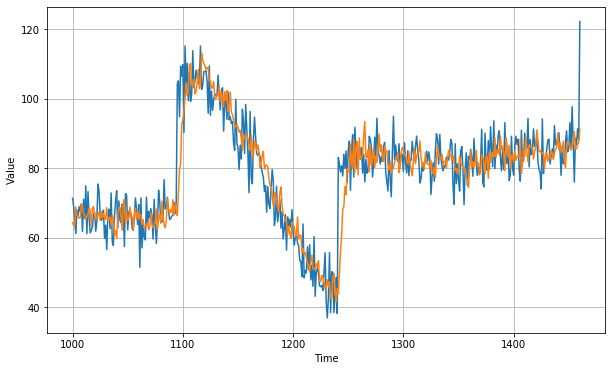

In [23]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dense_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, dense_forecast).numpy()
print("MAE:", mae)